# Understanding Algo quantile regressor

ref
* https://en.wikipedia.org/wiki/Quantile_regression
* regressor_model.py
* https://towardsdatascience.com/quantile-regression-ff2343c4a03  (Linear regression)
* https://towardsdatascience.com/lightgbm-for-quantile-regression-4288d0bb23fd  (LIGHTGBM)
* https://www.kaggle.com/code/mavillan/lightgbm-quantile-regression/notebook
* https://www.statsmodels.org/dev/datasets/generated/engel.html


## Motivations for quantile regression

Disambiquation

* Linear Quantile Regressor (Statistics)
    * alternative to linear regression when there is Heteroscedasticity. Can be seen as generalization of Lnear regression
    * assumptions  (https://stats.stackexchange.com/questions/320991/what-are-the-assumptions-for-applying-a-quantile-regression-model)
        * no assumtions about the target distributions  (*8The main motivation**)
        * linearity of the coeficients (LighGBM does not have this assumtions)
        * independence of observations
        * very large sample size, as quantile regression is not very efficient
        * $y$ is "very" continuos    

* LightGBM quantile regressor (Machine Learning)
    * Quantile is used to predict intervals of target variable
    * The main difference related to generic regression is the loss function:
        * pinball loss: pos slope is $\tau $ and negative slope is $ (1 - \tau)$ (https://www.lokad.com/pinball-loss-function-definition#:~:text=The%20pinball%20loss%20function%20is,forecast%20is%20a%20subtle%20problem.)
            * $ \tau = 0.5 $ = 0.5 the loss is symetric
            * $ \tau < 0.5 $ penalizes more the positive error (see inclimation of the loss) 
            * $ \tau > 0.5 $ penalizes more the negative side
        * based on R doc: https://astrostatistics.psu.edu/datasets/R/html/quantreg/html/rq.html
            * $ \tau $ is the quantile to be predict, so in python is $ \alpha $ 
        * LIGHGBM $ \alpha $ is the quantile we want to predict


In [2]:
import IPython
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
import sys
# printing all paths
sys.path

# appending a path
repo = '/home/ubuntu/leandro-algopricing-analytics'
sys.path.append(repo)

import pandas as pd
pd.set_option("display.precision", 2)
# settings to display all columns
pd.set_option("display.max_columns", None)

import seaborn as sns

from datetime import datetime, date

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/ubuntu/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/ubuntu/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

## Loss funtion

1. Assymetric penalizing negative vs positive errors allows to predict different quantiles (below or above the median)
1. The loss symetric to predict the meadian value

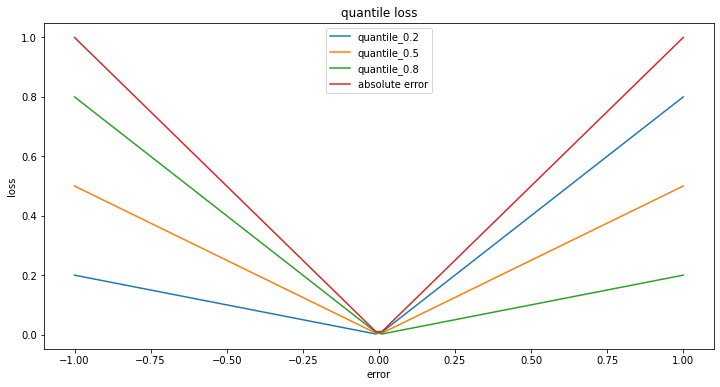

In [6]:
from sklearn.metrics import mean_absolute_error, mean_square_error
# Shameless stolen from: 
# https://github.com/MJeremy2017/Machine-Learning-Models/blob/master/quantile-regression/lgb-quantile-regression.ipynb
def quantile_loss(y_true, y_pred, q):
    return np.max([q*(y_true - y_pred), (1-q)*(y_pred-y_true)], axis=0)


def absolute_loss(y_true, y_pred):
    
    return np.abs(y_true - y_pred)

sample_size = 100
y_true = np.zeros(sample_size)

error = np.linspace(-1, 1, 100)
y_pred = error

quantiles = [0.2, 0.5, 0.8]

plt.figure(figsize=[12, 6])
for q in quantiles:
    losses = quantile_loss(y_true, y_pred, q)
    plt.plot(y_pred, losses, label=f'quantile_{q}')

# TODO: Add comparison with mse loss
plt.plot(y_pred, mean_square_error(y_true,y_pred, square=True), label=f'root squre error')  # <== REVIEW

abs_loss = absolute_loss(y_true, y_pred)
plt.plot(error, abs_loss, label='absolute error');
plt.title('quantile loss');
plt.xlabel('error');
plt.ylabel('loss');
plt.legend();

## Algo code

```python 

def fit_quantile(self,params):
    pass
    alpha = .975
            if self.model=='LightGBM_lower':
                self.clf = TransformedTargetRegressor(regressor=lgb.LGBMRegressor(objective = 'quantile',
                alpha = 1 - alpha,**params),func=np.log1p, inverse_func=np.expm1)
            else:
                #logic for LightGBM_upper
                self.clf = TransformedTargetRegressor(regressor=lgb.LGBMRegressor(objective = 'quantile',
                alpha = alpha,**params),func=np.log1p, inverse_func=np.expm1)
```

## Lightgbm tutorial

In [7]:
from lightgbm import LGBMRegressor

### Sim data 1

* homoscedasticity

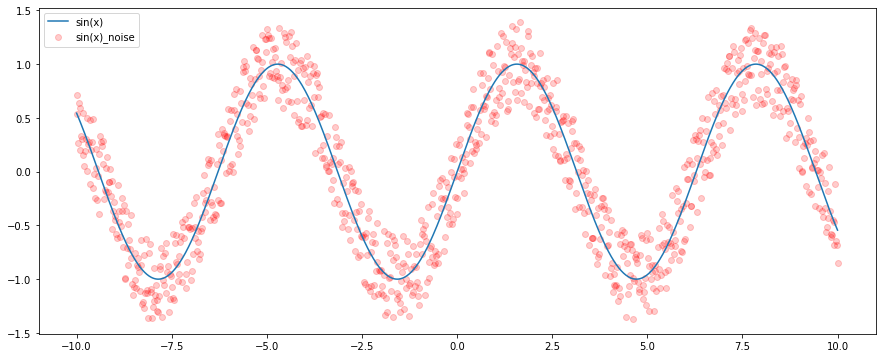

In [25]:
sample_size = 1000
x = np.linspace(-10, 10, sample_size)
signal = np.sin(x)
noise = np.random.uniform(-0.4, 0.4, sample_size) 
y = signal + noise

plt.figure(figsize=[15, 6]);
plt.plot(x, signal, label='sin(x)');
plt.scatter(x, y, label='sin(x)_noise', color='red', alpha=0.2);
plt.legend();

In [26]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 12,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}

y_preds = np.zeros((sample_size, 3))
quantiles = [.1, .5, .9]
x_train, y = x.reshape(-1, 1), y

for i in range(len(quantiles)):
    print('prediction of quantile', quantiles[i])
    lgb = LGBMRegressor(alpha=quantiles[i], **params)
    model = lgb.fit(x_train, y)
    y_preds[:, i] = model.predict(x_train)

prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9


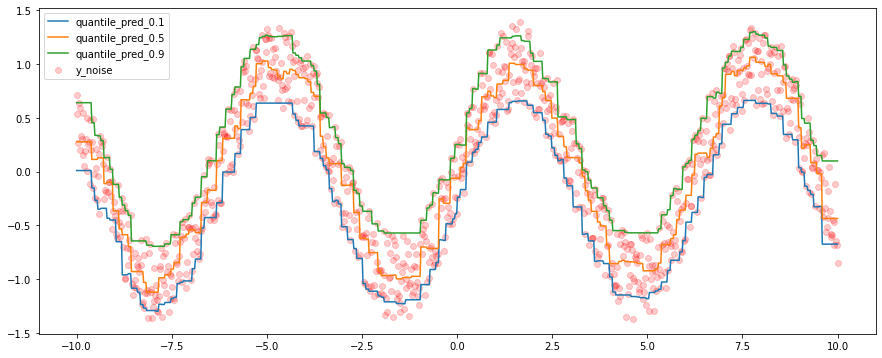

In [27]:
plt.figure(figsize=[15, 6])

plt.scatter(x, y, label='y_noise', alpha=.2, color='red');
for i in range(len(quantiles)):
    plt.plot(x, y_preds[:, i], label='quantile_pred_{}'.format(quantiles[i]));
plt.legend();

### Quantiles regressors are data hungry (not very efficient)

* TODO: review this experiment
    1. Is because it is not efficient and need data to work 
    1. Or it is because we are overfitting 
    1. The ladder/discrete behavours of the curves is because of the decisiont tree nature of ligtgbm?

sample size: 100
prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9


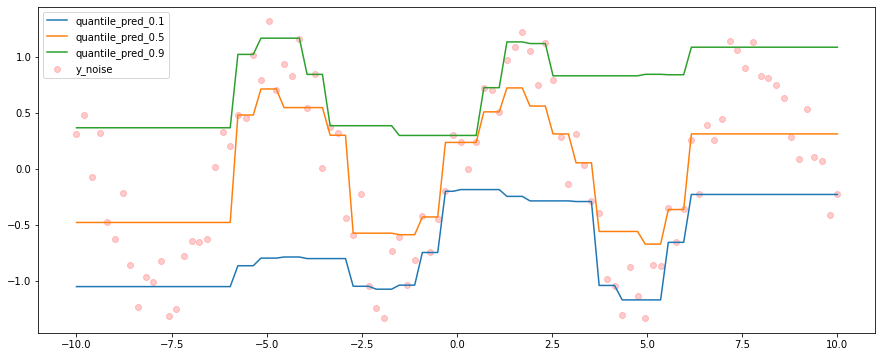

sample size: 250
prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9


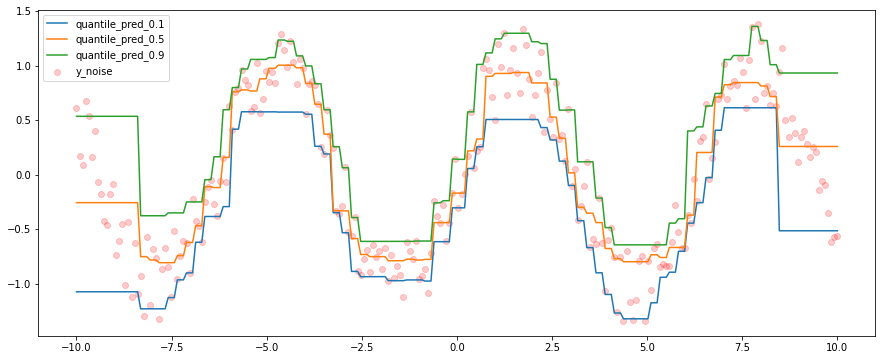

sample size: 500
prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9


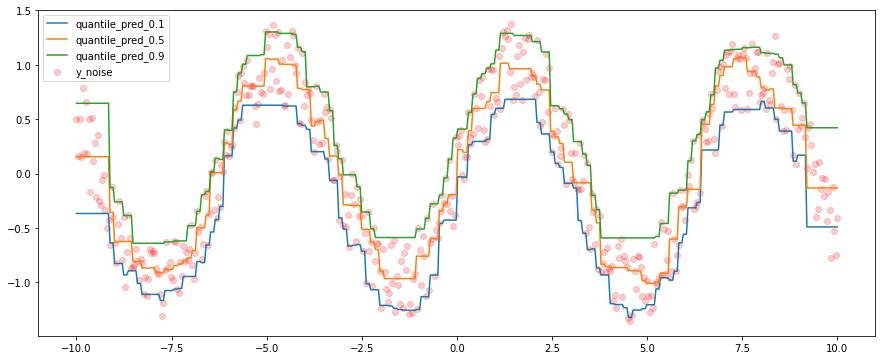

sample size: 1000
prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9


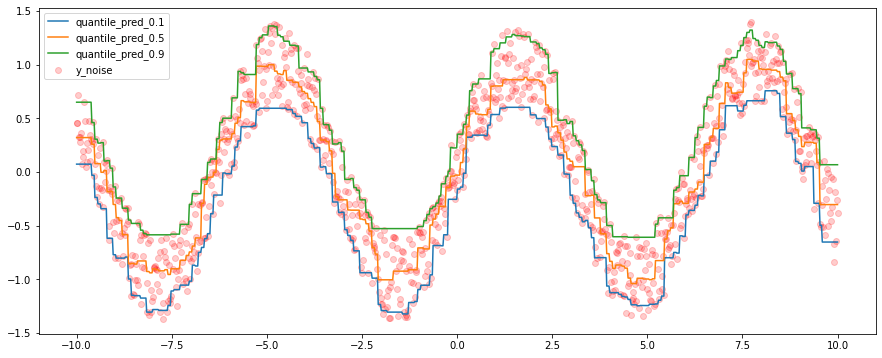

sample size: 2000
prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9


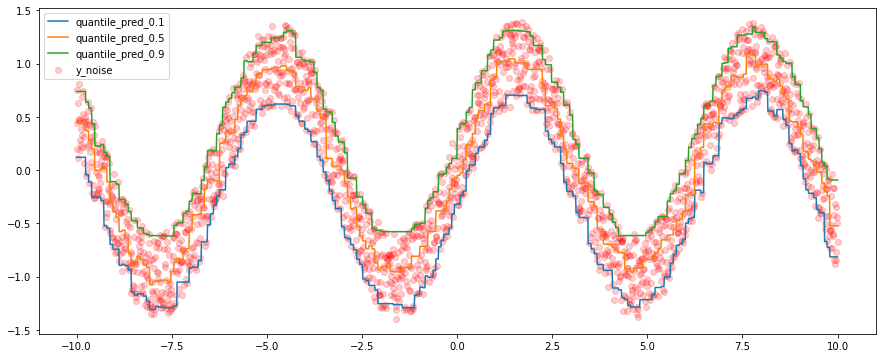

In [35]:
for sample_size in [100, 250, 500, 1000, 2000]:
    
    print(f"sample size: {sample_size}")
    # generate simulated data
    x = np.linspace(-10, 10, sample_size)
    signal = np.sin(x)
    noise = np.random.uniform(-0.4, 0.4, sample_size) 
    y = signal + noise
    
    y_preds = np.zeros((sample_size, 3))
    quantiles = [.1, .5, .9]
    x_train, y = x.reshape(-1, 1), y

    for i in range(len(quantiles)):
        print('prediction of quantile', quantiles[i])
        lgb = LGBMRegressor(alpha=quantiles[i], **params)
        model = lgb.fit(x_train, y)
        y_preds[:, i] = model.predict(x_train)
        
    _ = plt.figure(figsize=[15, 6]);
    _ = plt.scatter(x, y, label='y_noise', alpha=.2, color='red');
    
    for i in range(len(quantiles)):
        _ = plt.plot(x, y_preds[:, i], label='quantile_pred_{}'.format(quantiles[i]));

    _ = plt.legend();
    _ = plt.show();
    print("=====================")
    

### Sim data 2

* heteroskedasticity

In [89]:
# create some data
sample_size = 1000
x = np.random.uniform(low=-2.,high=2.,size=(sample_size,1))
noise  = np.random.normal(loc=0.,scale=1.*np.power(x,2))
signal = 1.5*np.sin(np.pi*x) 
y =  signal + noise 

x = x.reshape(-1, 1)
y = y.ravel()

x.shape
y.shape

x_grid = np.linspace(-2,2,sample_size).reshape(-1, 1) # <== for evaluation plots

(1000, 1)

(1000,)

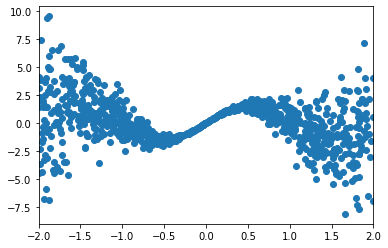

In [90]:
plt.scatter(x,y)
plt.xlim(-2,2)
plt.show();

In [91]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 2,
    'num_leaves': 10,
    'learning_rate': 0.1,
    'n_estimators': 150,
    'boosting_type': 'gbdt'
}

y_preds = np.zeros((sample_size, 3))
quantiles = [.05, .5, .95]

for i in range(len(quantiles)):
    print('prediction of quantile', quantiles[i])
    lgb = LGBMRegressor(alpha=quantiles[i], **params)
    model = lgb.fit(x, y)
    y_preds[:, i] = model.predict(x_grid)

prediction of quantile 0.05
prediction of quantile 0.5
prediction of quantile 0.95


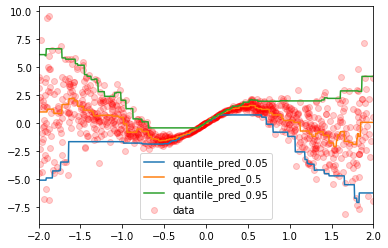

In [92]:
#plt.figure(figsize=[15, 6])

plt.scatter(x, y, label='data', alpha=.2, color='red')
for i in range(len(quantiles)):
    plt.plot(x_grid, y_preds[:, i], label='quantile_pred_{}'.format(quantiles[i]))
    
plt.xlim(-2,2)
plt.legend();

## Engel dataset
ref:
* https://www.statsmodels.org/dev/datasets/generated/engel.html

Notes:
1. Good for Heteroscedasticity 
1. Skeweed data (income)

```text
Number of observations: 235
Number of variables: 2
Variable name definitions:
    income - annual household income (Belgian francs)
    foodexp - annual household food expenditure (Belgian francs)
```

In [93]:
import statsmodels.api as sm

In [94]:
# food expenditure data
engel_data = sm.datasets.engel.load_pandas().data
engel_data.head()

,income,foodexp
0,420.16,255.84
1,541.41,310.96
2,901.16,485.68
3,639.08,403.00
4,750.88,495.56


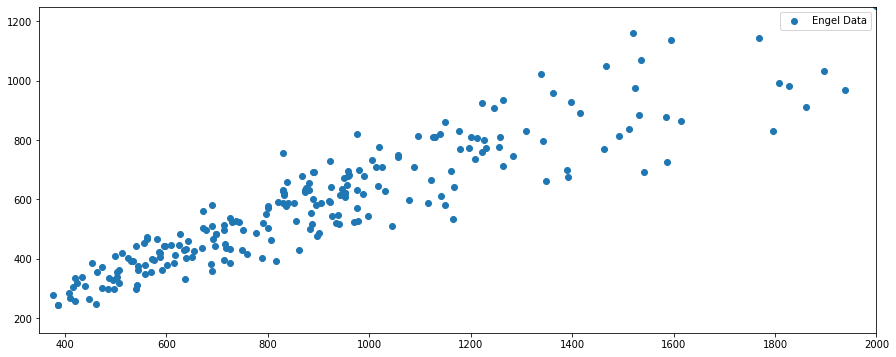

In [96]:
x = engel_data.income.to_numpy()
y = engel_data.foodexp.to_numpy()

plt.figure(figsize=[15, 6])
plt.scatter(x, y, label='Engel Data')
plt.ylim(150,1250)
plt.xlim(350,2000)
#plt.scatter(x, y, label='sin(x)_noise', color='red', alpha=0.2)
plt.legend();

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

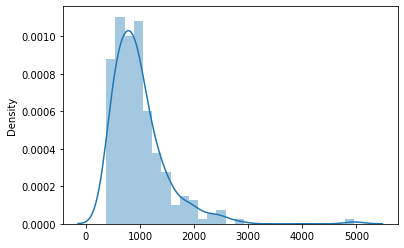

In [108]:
sns.distplot(x)

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


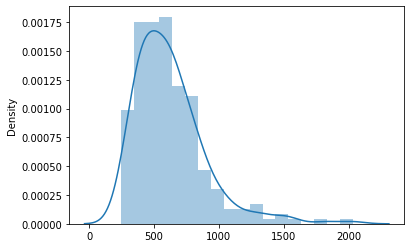

In [109]:
sns.distplot(y);

In [113]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}

sample_size = y.shape[0]
sample_size
x = x.reshape(-1, 1)
x.shape
y.shape

y_preds = np.zeros((y.shape[0], 5))
y_preds.shape

quantiles = [.05, 0.25, .5, 0.75, .95]

x_grid = np.linspace(x.min(), x.max(), sample_size).reshape(-1, 1)

for i in range(len(quantiles)):
    print('prediction of quantile', quantiles[i])
    lgb = LGBMRegressor(alpha=quantiles[i], **params)
    model = lgb.fit(x, y)
    y_preds[:, i] = model.predict(x_grid)

235

(235, 1)

(235,)

(235, 5)

prediction of quantile 0.05
prediction of quantile 0.25
prediction of quantile 0.5
prediction of quantile 0.75
prediction of quantile 0.95


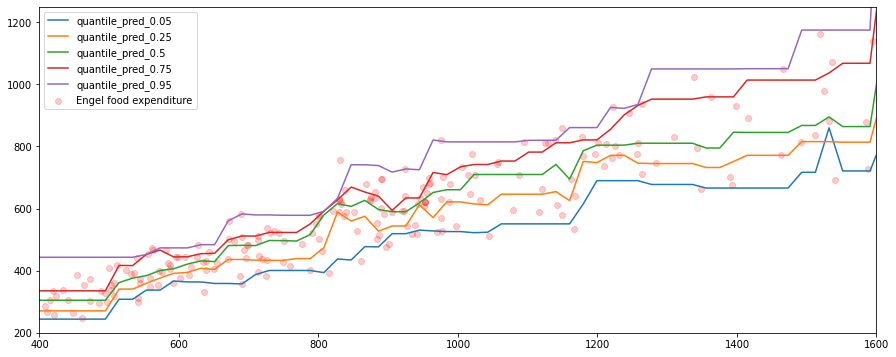

In [114]:
plt.figure(figsize=[15, 6])

plt.scatter(x, y, label='Engel food expenditure', alpha=.2, color='red')
for i in range(len(quantiles)):
    plt.plot(x_grid, y_preds[:, i], label='quantile_pred_{}'.format(quantiles[i]))

plt.ylim(200,1250)
plt.xlim(400,1600)
plt.legend();